In [ ]:
from toolbox.models import ResNet112, ResNet56
from toolbox.data_loader import Cifar100
from toolbox.utils import evaluate_model

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

device = "cuda"
BATCH_SIZE = 128


In [ ]:
model_path = r"toolbox/Cifar100_ResNet112.pth"
teacher = ResNet112(100).to(device)
teacher.load_state_dict(torch.load(model_path, weights_only=True)["weights"])
teacher.eval()

student = ResNet56(100).to(device)
student.train()


mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
Data = Cifar100(BATCH_SIZE)
trainloader, testloader = Data.trainloader, Data.testloader

evaluate_model(teacher, testloader)


In [ ]:
inputs, targets = next(iter(testloader))
inputs, targets = inputs.to(device), targets.to(device)

teacher_outputs = teacher(inputs)
student_outputs = student(inputs)

active_outputs = teacher_outputs

probs = torch.nn.functional.softmax(active_outputs[3], dim=1)
confidence, predicted = torch.max(probs.data, 1)

INDEX = 0

In [ ]:
predicted_class_label = testloader.dataset.classes[predicted[INDEX]]
correct_class_label = testloader.dataset.classes[targets[INDEX]]
print('predicted: ', predicted_class_label)
print('correct: ', correct_class_label)
print('confidence', confidence[INDEX].item())
img = inputs[INDEX].cpu() * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
img = img.permute(1, 2, 0).numpy()
plt.imshow(img)
plt.show()

In [139]:
def positive_normal_1(mean, std, shape):
    result = torch.empty(shape, device=device)
    filled = torch.zeros(shape, dtype=torch.bool, device=device)

    while not filled.all():
        new_vals = torch.normal(mean=mean, std=std, size=shape, device=device)
        mask = (new_vals > 0) & (~filled)
        result[mask] = new_vals[mask]
        filled |= mask

    return result

def positive_normal_2(mean,std,shape):
    noise = torch.normal(mean=mean, std=std, size=shape, device=device)
    positive_noise = noise.clamp(min=0)
    return positive_noise

def viz_fmap(feature_map):
    size = 2
    fig, axs = plt.subplots(size,size,figsize=(2,2))
    for i in range(size):
        for j in range(size):
            axs[i, j].matshow(feature_map[i+j*size].detach().cpu(), vmin=0, vmax=7.5)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

def print_ms(tens, label):
    print(f'{label} mean={tens.mean().item():.2f} std={tens.std().item():.2f}')

clean tensor mean=0.81 std=1.57


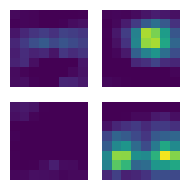

noise_multiplier=0.25, noise_mean=0.2, noise_std=0.375
noise mean=0.20 std=0.38
noisy tensor mean=1.00 std=1.61


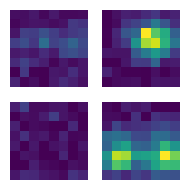

noise_multiplier=0.6875, noise_mean=0.55, noise_std=1.03125
noise mean=0.55 std=1.03
noisy tensor mean=1.36 std=1.88


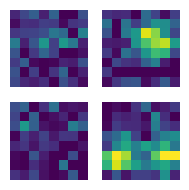

noise_multiplier=1.125, noise_mean=0.9, noise_std=1.6875
noise mean=0.90 std=1.69
noisy tensor mean=1.71 std=2.31


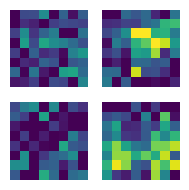

noise_multiplier=1.5625, noise_mean=1.25, noise_std=2.34375
noise mean=1.25 std=2.34
noisy tensor mean=2.05 std=2.82


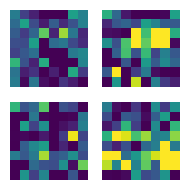

noise_multiplier=2.0, noise_mean=1.6, noise_std=3.0
noise mean=1.61 std=3.00
noisy tensor mean=2.41 std=3.39


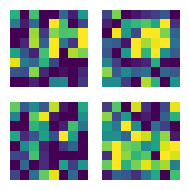

In [140]:
clean_tensor = active_outputs[2]
print_ms(clean_tensor, 'clean tensor')

feature_map = active_outputs[2][INDEX]
viz_fmap(feature_map)


for noise_multiplier in np.linspace(0.25, 2, 5): 
    noise_mean = 0.8 * noise_multiplier
    noise_std = 1.5 * noise_multiplier
    print(f'{noise_multiplier=}, {noise_mean=}, {noise_std=}')

    noise = torch.normal(mean=noise_mean, std=noise_std, size=clean_tensor.shape, device=device)
    # noise = positive_normal_1(noise_mean, noise_std, clean_tensor.shape)
    # noise = positive_normal_2(noise_mean, noise_std, clean_tensor.shape)
    print_ms(noise, 'noise')

    noisy_tensor = clean_tensor.detach() + noise 
    print_ms(noisy_tensor, 'noisy tensor')

    viz_fmap(noisy_tensor[INDEX])

Without tucker recomposition
clean tensor mean=0.81 std=1.57


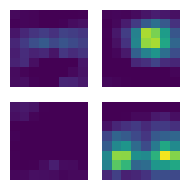

x0.5
reconstructed tensor mean=0.80 std=1.41


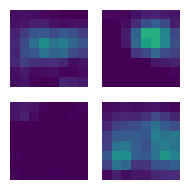

x0.375
reconstructed tensor mean=0.80 std=1.32


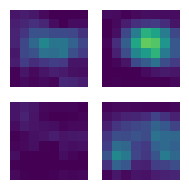

x0.25
reconstructed tensor mean=0.80 std=1.18


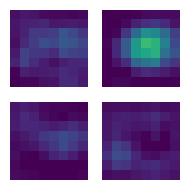

x0.125
reconstructed tensor mean=0.80 std=0.97


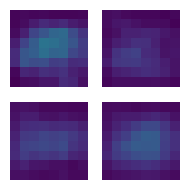

In [141]:
import tensorly as tl
from tensorly import tucker_to_tensor
tl.set_backend("pytorch")
def tucker(feature_map, rank=[BATCH_SIZE,32,8,8]): 
    core, factors = tl.decomposition.tucker(feature_map, rank=rank)
    return core, factors

def compute_core(feature_map, factors):
    return tl.tenalg.multi_mode_dot(feature_map, [f.T for f in factors], modes=[0, 1, 2, 3])

print('Without tucker recomposition')
print_ms(teacher_outputs[2], 'clean tensor')
viz_fmap(teacher_outputs[2][INDEX])
for channels in [32,24,16,8]:
    rank = [BATCH_SIZE, channels, 8, 8]
    teacher_core, teacher_factors = tucker(teacher_outputs[2], rank)

    teacher_reconstructed = tucker_to_tensor((teacher_core, teacher_factors))

    print(f'x{channels/64}') 
    print_ms(teacher_reconstructed, 'reconstructed tensor')
    viz_fmap(teacher_reconstructed[INDEX])